# Calculating multiproduct formula cost for time dependent spin model

The Hamiltonian we'll consider here is a 1D closed chain of $N$ qubits subject to the following Hamiltonian

$$H(t) =  J(t) H_0 + B(t) H_{pot} \\
J(t) = J_0 \quad B(t) = B \cos(\omega t) \\
H_{int} = \sum_{i=1}^N X_i X_{i+1} + Y_i Y_{i+1}, \quad H_{pot} = \sum_{i=1}^N X_i$$.

This Hamiltonian does not, in general, commute with itself at later times, though it is still relatively simple. 

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from scipy.special import lambertw

I = np.array([[1,0],[0,1]],dtype = 'complex')
X = np.array([[0,1],[1,0]],dtype='complex')
Y = np.array([[0,-1.j],[1.j,0]],dtype='complex')
Z = np.array([[1,0],[0,-1]],dtype='complex')

# Computes Kronecker (tensor) product of a list of matrices
def kron_list(matrix_list):
    result = matrix_list[0]
    for i in range(1,len(matrix_list)):
        result = np.kron(result,matrix_list[i])
        
    return result

# Converts string representation of paulis to list of matrices
def paulistring_to_list(paulistring): 
    matrix_list = list(paulistring)
    translate = {'I':I, 'X':X, 'Y':Y, 'Z':Z}
    for p in range(len(paulistring)):
        matrix_list[p] = translate[matrix_list[p]]
    return matrix_list

# Computes generalized pauli matrix, given a string in standard form
def pauli_matrix(paulistring):
    return kron_list(paulistring_to_list(paulistring))

# Computes generalized pauli matrix, specified by non-identity pieces. Nonidentities encoded as dictionary
def sparse_pauli(nonidentities, nqubits):
    #starting string is all identity
    paulilist = []
    for i in range(0,nqubits):
        paulilist.append('I')
    
    #Change string to paulis specified by dictionary
    for key in nonidentities:
        paulilist[key] = nonidentities[key]
    paulistring = ''.join(paulilist)
    
    return pauli_matrix(paulistring) 

def sigma_dot_sigma(i,j,nqubits):
    return sparse_pauli({i:'X',j:'X'},nqubits) + sparse_pauli({i:'Y',j:'Y'},nqubits) + sparse_pauli({i:'Z',j:'Z'},nqubits)

In [7]:
epsilon = 10**-6
T = 10
nqubits = 3

omega1 = 0

omega2 = 1
J0 = 1
B0 = 1

gamma = .5
kappa = 8

def H_hop(nqubits):
    result = sparse_pauli({0:'X',1:'X'},nqubits) + sparse_pauli({0:'Y',1:'Y'}, nqubits)
    for qubit in range(1, nqubits -1):
        result += sparse_pauli({qubit:'X',qubit+1:'X'},nqubits) 
        + sparse_pauli({qubit:'Y',qubit+1:'Y'}, nqubits)
    if nqubits > 2:
        result += sparse_pauli({nqubits-1:'X',0:'X'},nqubits) + sparse_pauli({nqubits-1:'Y',0:'Y'}, nqubits)
    return result

def H_pot(nqubits):
    paulistring = 'X'*nqubits
    return pauli_matrix(paulistring)

def H(t, nqubits):
    return J0*np.cos(omega1 * t) * H_hop(nqubits) + B0*np.cos(omega2*t) *H_pot(nqubits)

In [8]:
# Set K_scale to 1 to ensure proper rounding
def k(m, K_scale=1):
    j = np.arange(1, m+1)
    x = np.sin(np.pi*(2*j-1)/(8*m))**2
    #x = np.cos(np.pi*(2*j-1)/(8*m))**2
    return np.ceil((K_scale*np.sqrt(8) * m) /(np.pi*np.sqrt(x))).astype(int)

def a(k):
    m = len(k)
    result = np.ones(m, dtype = 'float')
    for n in range(m):
        for q in range(m):
            if q != n:
                result[n] *= k[n]**2/(k[n]**2-k[q]**2)
    return result
        
def one_norm(vector):
    return np.sum(np.abs(vector))

In [9]:
def U2(dt, t0):
    return la.expm(-1.j*H(t0+dt/2, nqubits)*dt)

# Defines symmetric sequence of applications of U2 formula, given a number of factors k
def U_seq(dt, t0, k):
    timestep = dt/k
    result = U2(timestep,t0)
    for q in range(1, k):
        result = U2(timestep, t0 + q*timestep) @ result
        
    return result

def U_k(dt, t0, order):
    k_vec = k(order, 1)
    a_vec = a(k_vec)
    
    result = a_vec[0]*U_seq(dt, t0, k_vec[0])
    for j in range(1,order):
        result += a_vec[j]*U_seq(dt, t0, k_vec[j])  
        
    return result

def U_MP(t, steps, order):
    timestep = t/steps
    result = U_k(timestep, 0, order)
    for step in range(1,steps):
        result = U_k(timestep, timestep*step,order) @ result
    return result

def m_opt():
    return np.ceil((-lambertw(-np.sqrt(epsilon/(7.8*np.e*Lambda*T)*np.log(1/gamma)),k=-1)).astype(float)/np.log(1/gamma))



In [12]:
Utrotter = U_seq(T, 0, 1000)
Ump = U_MP(T, 10, 3)
print(Ump)

[[ 0.35947293-0.60474826j -0.16834968-0.05917127j -0.16834968-0.05917127j
  -0.17322698-0.18197823j  0.11008023-0.10478653j -0.0978185 +0.27830588j
  -0.0978185 +0.27830588j  0.36581756+0.21744834j]
 [-0.16834968-0.05917127j -0.46148324-0.06949306j  0.25645518+0.39599009j
   0.05181079-0.26874433j -0.44427247-0.08565058j -0.2395379 +0.155132j
   0.04203697-0.27915528j -0.0978185 +0.27830588j]
 [-0.16834968-0.05917127j  0.25645518+0.39599009j -0.46148324-0.06949306j
   0.05181079-0.26874433j -0.44427247-0.08565058j  0.04203697-0.27915528j
  -0.2395379 +0.155132j   -0.0978185 +0.27830588j]
 [-0.17322698-0.18197823j  0.05181079-0.26874433j  0.05181079-0.26874433j
  -0.03180108+0.50847525j -0.30758117-0.01923675j -0.44427247-0.08565058j
  -0.44427247-0.08565058j  0.11008023-0.10478653j]
 [ 0.11008023-0.10478653j -0.44427247-0.08565058j -0.44427247-0.08565058j
  -0.30758117-0.01923675j -0.03180108+0.50847525j  0.05181079-0.26874433j
   0.05181079-0.26874433j -0.17322698-0.18197823j]
 [-0.09

# Scaling of MPF with respect to system size on nearest neighbor XX model

We are now going to compare our formula for multiproduct formula scaling with what we actually find in a numerical simulation. We will consider the XX Hamiltonian above, fixing the error tolerance $\epsilon$ at, say $10^{-3}$, as well as the Hamiltonian parameters and $T$. We'll then look at scaling with $N_{spins}$, which is an important figure of merit for quantum many body systems. To facilitate the comparison, we'll perform time dependent Trotter to a guaranteed accuracy of within $10^{-6}$, well smaller than the errors we'll be considering for the multiproducts. 

First, we'll choose a Hamiltonian such that $\Lambda = \left\|H(t)\right\|$. This can be done with the simple choice $J_0 = B_0 = \omega = 1$, among others. The important thing is that the frequency is not too large compared to the coupling $J_0$. We'll be using the lowest order symmetric Trotter formula in our comparison, and borrowing an expression from Wiebe's 2010 paper that gives us an error bound guarantee using a certain number of steps. I am only trotterizing the time steps for the benchmark Trotter, I don't need to go further because I can numerically exponentiate to machine precision. 

In [68]:
def trotter_steps_bounds(T, epsilon, nspins, J0, B0):
    return np.ceil(25* nspins * (2*J0 + B0)*T*np.sqrt(nspins*(2*j0+B0)*T/epsilon))

def m_theory(T, epsilon, nspins, J0,B0, gamma):
    return (-lambertw(-np.sqrt(epsilon/(7.8*np.e*nspins*(2*J0+B0)*T)*np.log(1/gamma)),k=-1)).astype(float)/np.log(1/gamma)


def mp_steps_bound(T, epsilon, nspins, J0, B0, gamma, kappa):
            return 6*kappa*np.e*nspins*(2*J0+B0)*T/gamma * m_theory(T, epsilon, nspins, J0,B0, gamma)**4 * np.log(m_theory(T, epsilon, nspins, J0, B0, gamma))
    


In [31]:
mp_steps_bound(10, 10**-3, 10, 1,1, .5, 2) # This is too big

/var/folders/3l/pxpt0wt16dg1x_r0_s6zy09r0000gn/T/ipykernel_39838/2440703899.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ceil((-lambertw(-np.sqrt(epsilon/(7.8*np.e*nspins*(2*J0+B0)*T)*np.log(1/gamma)),k=-1)).astype(float)/np.log(1/gamma))


2683173311.23091

In [71]:
m_theory(0.0001, 10**-3, 1, 1,1, .3)

/var/folders/3l/pxpt0wt16dg1x_r0_s6zy09r0000gn/T/ipykernel_39838/1428815526.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  return (-lambertw(-np.sqrt(epsilon/(7.8*np.e*nspins*(2*J0+B0)*T)*np.log(1/gamma)),k=-1)).astype(float)/np.log(1/gamma)


0.7373553071622415

/var/folders/3l/pxpt0wt16dg1x_r0_s6zy09r0000gn/T/ipykernel_39838/1428815526.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return (-lambertw(-np.sqrt(epsilon/(7.8*np.e*nspins*(2*J0+B0)*T)*np.log(1/gamma)),k=-1)).astype(float)/np.log(1/gamma)
/var/folders/3l/pxpt0wt16dg1x_r0_s6zy09r0000gn/T/ipykernel_39838/1428815526.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  return (-lambertw(-np.sqrt(epsilon/(7.8*np.e*nspins*(2*J0+B0)*T)*np.log(1/gamma)),k=-1)).astype(float)/np.log(1/gamma)


Text(0, 0.5, 'order')

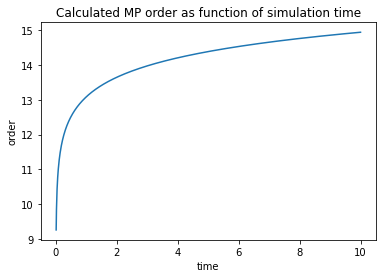

In [69]:
t = np.linspace(0,10,1000)
m_value = m_theory(t,10**-3,10,1,1,.5)

plt.plot(t, m_value)
plt.title('Calculated MP order as function of simulation time')
plt.xlabel('time')
plt.ylabel('order')

We see the correct logarithmic dependence of the MP order $m$ on the simulation time. However, it seems there's a high constant shift, since even short times yield a relatively high $m$. We see similar behavior in the number of MP steps, where the scaling is good as theoretically calculated, but the bound is extremely high! I'm sure the actual values we'll see will be much lower.